In [3]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import glob
import torch
import pandas as pd
import matplotlib.pyplot as plt
import gc
import torchvision

from os.path import join as join_path

from PIL import Image
from torchvision import transforms

In [4]:
PATH_TO_FOLDER = '/home/jovyan/work/'
path = join_path(PATH_TO_FOLDER, 'run_attacks')
SAVE_PATH = join_path(PATH_TO_FOLDER, 'run_attacks', 'tmp_results')

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
DEVICE = device
print(device)

cuda:0


# Example

In [6]:
from torchvision import transforms
from torch.autograd import Variable

In [7]:
def adv(ref, eps):
    image = transforms.ToTensor()(ref)
    image = image.unsqueeze_(0)
    image = image.to(DEVICE)
    image = Variable(image, requires_grad=True)

    model = Linearity(DEVICE)
    score = model(image)
    print("linearity score:", score.item())
    loss = 1 - score / 100
    loss.backward() 
    g = image.grad
    g = torch.sign(g)
    image.data -= eps * g
    image.data.clamp_(0., 1.)
    image.grad.zero_()

    res_image = (image).data.clamp_(min=0, max=1)
    res_img = (res_image.squeeze().data.cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')
    return res_img

In [8]:
# images = sorted(os.listdir('test_ims'))
# im = cv2.imread('test_ims/'+images[0])
# im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
# eps = 10/255
# im = adv(im, eps)
# im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
# os.makedirs('res_fgsm', exist_ok=True)
# cv2.imwrite('res_fgsm/'+images[0], im)

# Run IQA models

In [ ]:
alltype_folder = 'TID2013/distorted_images' # val2017 train2017 test2017
_type_folder = 'train2017'

# _type_folder = 'KADID10K/kadid10k/images'
# image_type_folder = 'kadid10k'

all_images = sorted(glob.glob(join_path(PATH_TO_FOLDER, 'data', _type_folder, '*')))
image_type_folder = f'mscoco_{_type_folder}'
# image_type_folder = _type_folder
# image_type_folder = 'tid2013'

len(all_images)

In [13]:
alltype_folder = 'TID2013/distorted_images' # val2017 train2017 test2017
_type_folder = 'train2017'

# _type_folder = 'KADID10K/kadid10k/images'
# image_type_folder = 'kadid10k'

all_images = [join_path(PATH_TO_FOLDER, 'data', _type_folder, '000000009898.jpg'), join_path(PATH_TO_FOLDER, 'data', _type_folder, '000000333018.jpg')]
image_type_folder = f'mscoco_{_type_folder}'
# image_type_folder = _type_folder
# image_type_folder = 'tid2013'

In [15]:
os.path.exists(all_images[0]), os.path.exists(all_images[1])

(True, True)

In [16]:
# df = pd.read_csv(join_path(PATH_TO_FOLDER, 'data', 'KADID10K', 'images_HackPredictModelV31_padding.csv'))
# df['distortion_type'] = df['image_name'].apply(lambda x: int(x.split('_')[1]) if len(x) != 7 else 0)
# ims = list(set(df[df['distortion_type'] == 6]['image_name'])) + list(set(df[df['distortion_type'] == 22]['image_name']))
# all_images = [join_path(PATH_TO_FOLDER, 'data', 'KADID10K', 'kadid10k', 'images', i) for i in ims]
# all_images = sorted(all_images)

# image_type_folder = 'kadid10k_only_6_22'

# len(all_images)

## Linearity

In [17]:
from argparse import ArgumentParser
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import resize, to_tensor, normalize
from PIL import Image
# import h5py

In [18]:
os.chdir(join_path(PATH_TO_FOLDER, 'metrics', 'Linearity'))
from IQAmodel import IQAModel

In [19]:
model = IQAModel().to(device)
model_path = '/home/jovyan/storage/NR-metric-models/p1q2.pth'
checkpoint = torch.load(model_path)
k = checkpoint['k']
b = checkpoint['b']
model.load_state_dict(checkpoint['model'])
model.eval();

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

In [50]:
C = 3
eps = C / 255
fname = f'fgsm_{C}_255_linearity_{image_type_folder}.csv'
fname

'fgsm_3_255_linearity_mscoco_train2017.csv'

In [51]:
res = []
gains = []
for image_file in tqdm(all_images[1:]):
    image = Image.open(image_file).convert('RGB')
    image = resize(image, (498, 664))
    image = to_tensor(image).to(device)
    image = image.unsqueeze(0)
    image = Variable(image, requires_grad=True)
    
    norm_image = normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    score = model(norm_image)[-1]
    
    before_score = score * k[-1] + b[-1]
    loss = 1 - before_score / 100
    loss.backward()
    g = image.grad
    g = torch.sign(g).squeeze(0)
    image.data -= eps * g
    image.grad.zero_()

    image = image.data.clamp_(min=0, max=1)
    image_after_attack = (image.squeeze().data.cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')
    
    image = to_tensor(image_after_attack)
    image = normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        y = model(image)[-1].cpu().detach().item()
        after_score = y * k[-1] + b[-1]
    
    before_score = before_score.cpu().detach().item()
    
    gains.append([before_score, after_score])
    res.append([image_file.split('/')[-1], before_score, after_score])
gains = np.array(gains)

df = pd.DataFrame(res, columns=['image_name', 'before_score', 'after_score'])
df['attack_type'] = f'fgsm_{C}_255'
df['metric'] = 'lin'

x = (gains[:, 1] - gains[:, 0]) # .mean()
x.mean()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


81.76475919437758

In [23]:
# image

In [ ]:
df.to_csv(join_path(SAVE_PATH, fname))

In [52]:
# qq = (g.squeeze().data.cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')
# plt.imshow(qq)
# plt.axis('off')
# plt.savefig('/home/jovyan/work/data/fgsm_delta_000000134034.jpg', bbox_inches='tight')

# qq = (g.squeeze().data.cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')
# plt.imshow(qq)
# plt.savefig('/home/jovyan/work/data/fgsm_delta_000000134034.jpg')

# Image.fromarray(image_after_attack).save('000000134034_attack_fgsm.jpg')
# Image.open(image_file).convert('RGB').save('000000134034.jpg')

In [53]:
image_file

'/home/jovyan/work/data/train2017/000000333018.jpg'

In [54]:
!pwd

/home/jovyan/work/metrics/Linearity


In [55]:
Image.fromarray(image_after_attack).save('000000333018_attack_fgsm_30.jpg')

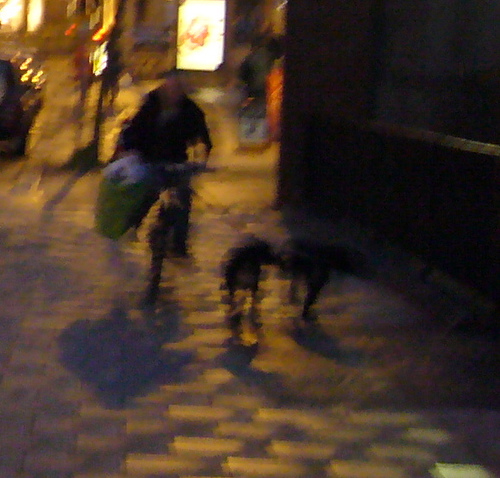

In [49]:
Image.open(image_file).convert('RGB')

## Paq-2-Piq

In [ ]:
# xx = [join_path(PATH_TO_FOLDER, 'data', 'train2017', '000000421682.jpg'),
#      join_path(PATH_TO_FOLDER, 'data', 'train2017', '000000217090.jpg')]

In [ ]:
os.environ['my_device'] = str(device)

os.chdir(join_path(PATH_TO_FOLDER, 'metrics', 'Paq-2-Piq'))
from paq2piq_standalone import InferenceModel, RoIPoolModel

In [ ]:
# model = InferenceModel(RoIPoolModel().to(device), 'D:\\me\\iqa_aimasters\\metrics\\Paq-2-Piq\\RoIPoolModel.pth')

In [ ]:
model = RoIPoolModel()
model_path = join_path(PATH_TO_FOLDER, 'metrics', 'Paq-2-Piq', 'RoIPoolModel.pth')
model_state = torch.load(model_path, map_location=lambda storage, loc: storage)
model.load_state_dict(model_state["model"])
model.to(device)
model.eval();

In [ ]:
p2p_transform = transforms.ToTensor()

In [ ]:
C = 5
eps = C / 255

In [ ]:
res = []
gains = []
for image_file in tqdm(all_images):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = p2p_transform(image).to(device)
    norm_image = image.unsqueeze(0)
    norm_image = Variable(norm_image, requires_grad=True)
    model.input_block_rois((20, 20), [image.shape[-2], image.shape[-1]], device=device)
    score = model(norm_image)[0][0]
    before_score = score.item()
    # print(before_score)
    loss = 1 - score / 100
    loss.backward()
    g = norm_image.grad
    g = torch.sign(g).squeeze(0)
    image.data -= eps * g
    norm_image.grad.zero_()

    image = image.data.clamp_(min=0, max=1)
    image_after_attack = (image.squeeze().data.cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')
    # plt.imshow(image_after_attack)
    image = p2p_transform(image_after_attack).unsqueeze(0).to(device)
    
    after_score = model(image).data.cpu().numpy()[0][0]
    # print(after_score)
    gains.append([before_score, after_score])
    res.append([image_file.split('/')[-1], before_score, after_score])
gains = np.array(gains)

df = pd.DataFrame(res, columns=['image_name', 'before_score', 'after_score'])
df['attack_type'] = f'fgsm_{C}_255'
df['metric'] = 'p2p'

x = (gains[:, 1] - gains[:, 0]) # .mean()
x.mean()

In [ ]:
fname = f'fgsm_{C}_255_p2p_{image_type_folder}.csv'
df.to_csv(join_path(SAVE_PATH, fname))

In [ ]:
torch.cuda.empty_cache()
gc.collect()

## Nima

In [ ]:
# os.chdir('D:\\me\\iqa_aimasters\\metrics\\Nima\\nima')

In [ ]:
# %load_ext autoreload
# %autoreload 2
# from inference.inference_model import InferenceModel

# path_to_model_weight = "D:\\me\\iqa_aimasters\\metrics\\Nima\\pretrain-model.pth" 
# model = InferenceModel(path_to_model=path_to_model_weight)

In [ ]:
# C = 10
# eps = C / 255

In [ ]:
# res = []
# gains = []
# for image_file in tqdm(all_images):
#     im = Image.open(image_file).convert('RGB')
#     image = model.transform(im)
#     image = image.to(device)
#     norm_image = image.unsqueeze(0)
#     norm_image = Variable(norm_image, requires_grad=True)
#     prob = model.model(norm_image)[0]
#     score = (model.const_nima * prob).sum()
#     before_score = score.item()
    
#     loss = 1 - score / 100
#     loss.backward()
#     g = norm_image.grad
#     g = torch.sign(g).squeeze(0)
#     image.data -= eps * g
#     norm_image.grad.zero_()

#     image = image.data.clamp_(min=0, max=1)
#     image_after_attack = (image.squeeze().data.cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')    
#     with torch.no_grad():
#         after_score = model.predict_from_pil_image(Image.fromarray(image_after_attack))['mean_score']
    
#     gains.append([before_score, after_score])
#     res.append([image_file.split('\\')[-1], before_score, after_score])
    
# gains = np.array(gains)

# df = pd.DataFrame(res, columns=['image_name', 'before_score', 'after_score'])
# df['attack_type'] = f'fgsm_{C}_255'
# df['metric'] = 'nima'

# x = (gains[:, 1] - gains[:, 0])
# x.mean()

In [ ]:
# fname = f'fgsm_{C}_255_nima_mscoco_val2017'
# df.to_csv(join_path(PATH_TO_FOLDER, 'results', f'{fname}.csv'))

## SPAQ

In [ ]:
os.chdir(join_path(PATH_TO_FOLDER, 'metrics', 'SPAQ'))

In [ ]:
import numpy as np
from torchvision import transforms
from PIL import Image
import torch

In [ ]:
from Prepare_image import Image_load


class Baseline(torch.nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.backbone = torchvision.models.resnet50(pretrained=False)
        fc_feature = self.backbone.fc.in_features
        self.backbone.fc = torch.nn.Linear(fc_feature, 1, bias=True)

    def forward(self, x):
        result = self.backbone(x)
        return result

model = Baseline()
model_path = '/home/jovyan/storage/NR-metric-models/BL_release.pt'
checkpoint = torch.load(model_path, device)
model.load_state_dict(checkpoint['state_dict'])
model.to(device);
model.eval();

prepare_image = Image_load(size=512, stride=224)

to_tensor = transforms.ToTensor()

In [ ]:
# class Image_load(object):
#     def __init__(self, size, stride, interpolation=Image.BILINEAR):
#         assert isinstance(size, int)
#         self.size = size
#         self.stride = stride
#         self.interpolation = interpolation

#     def __call__(self, img):
#         image = self.adaptive_resize(img)
#         return image.unsqueeze(0)
       
#     def adaptive_resize(self, img):
#         """
#         Args:
#             img (PIL Image): Image to be scaled.

#         Returns:
#             PIL Image: Rescaled image.
#         """
#         h, w = img.size
#         if h < self.size or w < self.size:
#             return transforms.ToTensor()(img)
#         else:
#             return transforms.ToTensor()(transforms.Resize(self.size, self.interpolation)(img))

#     def to_numpy(self, image):
#         p = image.numpy()
#         return p.transpose((1, 2, 0))
    
# prepare_image = Image_load(size=512, stride=224)

In [ ]:
eps = 5 / 255
fname = f'fgsm_{int(eps * 255)}_255_spaq_{image_type_folder}.csv'
print(fname)

In [ ]:
res = []
gains = []
for image_file in tqdm(all_images):  
    before_score = -1
    try:
        # image = prepare_image(Image.open(image_file).convert('RGB'), attack=False).to(device)
        # before_score = model(image).mean().cpu().detach().cpu().item()
        image = prepare_image(Image.open(image_file).convert('RGB'), attack=True).to(device)
    except:
        res.append([image_file.split('/')[-1], -1, -1])
        continue
        
    image = Variable(image, requires_grad=True)
    
    score = model(image).mean()
    
    loss = 1 - score / 100
    loss.backward()
    g = image.grad
    g = torch.sign(g).squeeze(0)
    image.data -= eps * g
    image.grad.zero_()

    image = image.data.clamp_(min=0, max=1)
    image_after_attack = (image.squeeze().data.cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')
    
    # img = to_tensor(Image.fromarray(image_after_attack)).unsqueeze(0).to(device)
    try:
        try:
            img = prepare_image(Image.fromarray(image_after_attack).convert('RGB'), attack=False).to(device)
            with torch.no_grad():
                after_score = model(img).mean().detach().cpu().item()
        except:
            img = prepare_image(Image.fromarray(image_after_attack).convert('RGB'), attack=True).to(device)
            with torch.no_grad():
                after_score = model(img).mean().detach().cpu().item()
    except:
        after_score = -1
        
    # before_score = before_score.cpu().detach().cpu().item()
    
    gains.append([before_score, after_score])
    res.append([image_file.split('/')[-1], before_score, after_score])
gains = np.array(gains)


df = pd.DataFrame(res, columns=['image_name', 'before_score', 'after_score'])
df['attack_type'] = f'fgsm_{int(eps * 255)}_255'
df['metric'] = 'spaq'

print("gain diff: ", (gains[:, 1] - gains[:, 0]).mean())
print("gain percent:", ((gains[:, 1] - gains[:, 0]) / gains[:, 0]).mean())

In [ ]:
df.to_csv(join_path(SAVE_PATH, fname))

## KonCept512

In [ ]:
import torch.nn as nn
import argparse
import os
from torchvision.transforms import ToTensor, Resize, Normalize
from torchvision import transforms

In [ ]:
os.chdir(join_path(PATH_TO_FOLDER, 'metrics', 'KonCept512'))

from inceptionresnetv2 import inceptionresnetv2

In [ ]:
class model_qa(nn.Module):
    def __init__(self,num_classes,**kwargs):
        super(model_qa,self).__init__()
        base_model = inceptionresnetv2(num_classes=1000, pretrained='imagenet')
        self.base = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(1536, 2048),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(2048),
            nn.Dropout(p=0.25),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.25),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),         
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self,x):
        x = self.base(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x    

In [ ]:
KonCept512 = model_qa(num_classes=1)
KonCept512.load_state_dict(torch.load('/home/jovyan/storage/NR-metric-models/KonCept512.pth'))
KonCept512.eval().to(device);

In [ ]:
koncept_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384, 512))
        # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
koncept_normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
C = 2
eps = C / 255

In [ ]:
res = []
gains = []
for image_file in tqdm(all_images):
    image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
    image = koncept_transform(image).to(device)
    norm_image = koncept_normalize(image).unsqueeze(0)
    norm_image = Variable(norm_image, requires_grad=True)
    before_score = KonCept512(norm_image)[0][0]
    
    loss = 1 - before_score / 100
    loss.backward()
    g = norm_image.grad
    g = torch.sign(g).squeeze(0)
    image.data -= eps * g
    norm_image.grad.zero_()
    
    before_score = before_score.detach().cpu().item()

    image = image.data.clamp_(min=0, max=1)
    image_after_attack = (image.squeeze().data.cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')
    image = koncept_transform(image_after_attack).to(device)
    image = koncept_normalize(image).unsqueeze(0)

    with torch.no_grad():
        after_score = KonCept512(image)[0][0].detach().cpu().item()
        
    gains.append([before_score, after_score])
    res.append([image_file.split('\\')[-1], before_score, after_score])
gains = np.array(gains)

df = pd.DataFrame(res, columns=['image_name', 'before_score', 'after_score'])
df['attack_type'] = f'fgsm_{C}_255'
df['metric'] = 'koncept'

x = gains[:, 1] - gains[:, 0]
x.mean()

In [ ]:
fname = f'fgsm_{C}_255_koncept_{image_type_folder}.csv'
df.to_csv(join_path(SAVE_PATH, fname))

## MDTVSFA

In [ ]:
import torch
import random
# from torchvision import transforms
import skvideo.io
from PIL import Image
import numpy as np

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.utils.backcompat.broadcast_warning.enabled = True

In [ ]:
os.chdir(join_path(PATH_TO_FOLDER, 'metrics', 'MDTVSFA'))

# from CNNfeatures import get_features
from VQAmodel import VQAModel
from CNNfeatures import CNNModel

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
to_tensor = transforms.ToTensor()

In [ ]:
model = VQAModel().to(device)
model.load_state_dict(torch.load('/home/jovyan/storage/NR-metric-models/MDTVSFA.pt'))  #

In [ ]:
# get features
extractor = CNNModel(model='ResNet-50').to(device);

In [ ]:
model.train();
extractor.eval();

In [ ]:
eps = 2 / 255

In [ ]:
res = []
gains = []
i = 0
for image_file in tqdm(all_images):
    i += 1
    image = Image.open(image_file).convert('RGB')    
    norm_image = transform(image).unsqueeze(0)
    image = to_tensor(image)
    norm_image = Variable(norm_image, requires_grad=True)
    
    features_mean, features_std = extractor(norm_image.to(device))
    features = torch.cat((features_mean, features_std), 1).squeeze()
    features = torch.unsqueeze(features, 0)
    input_length = features.shape[1] * torch.ones(1, 1, dtype=torch.long)
    before_score = model((features, input_length))[0]
        
    loss = 1 - before_score / 100
    loss.backward()
    g = norm_image.grad
    g = torch.sign(g).squeeze(0)
    image.data -= eps * g
    norm_image.grad.zero_()
    
    before_score = before_score.detach().cpu().item()

    image = image.data.clamp_(min=0, max=1)
    image_after_attack = (image.squeeze().data.cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')
    image = transform(image_after_attack).unsqueeze(0)

    with torch.no_grad():
        features_mean, features_std = extractor(image.to(device))
        features = torch.cat((features_mean, features_std), 1).squeeze()
        features = torch.unsqueeze(features, 0)
        input_length = features.shape[1] * torch.ones(1, 1, dtype=torch.long)
        after_score = model((features, input_length))[0]
        after_score = after_score.detach().cpu().item()
        
    gains.append([before_score, after_score])
    res.append([image_file.split('/')[-1], before_score, after_score])
    
    if i % 10000 == 0:
        df = pd.DataFrame(res, columns=['image_name', 'before_score', 'after_score'])
        df['attack_type'] = f'uap_{int(eps * 255)}_255' # wrong
        df['metric'] = 'mdtvsfa'
        fname = f'fgsm_{int(eps * 255)}_255_mdtvsfa_{image_type_folder}_{i}.csv'
        df.to_csv(join_path(SAVE_PATH, fname))
    
    
gains = np.array(gains)

df = pd.DataFrame(res, columns=['image_name', 'before_score', 'after_score'])
df['attack_type'] = f'fgsm_{int(eps * 255)}_255'
df['metric'] = 'mdtvsfa'

In [ ]:
print("gain diff: ", (gains[:, 1] - gains[:, 0]).mean())
print("gain percent:", ((gains[:, 1] - gains[:, 0]) / gains[:, 0]).mean())

In [ ]:
fname = f'fgsm_{int(eps * 255)}_255_mdtvsfa_{image_type_folder}.csv'
df.to_csv(join_path(SAVE_PATH, fname))

In [ ]:
image_type_folder

In [ ]:
x = (gains[:, 1] - gains[:, 0]) / gains[:, 0]

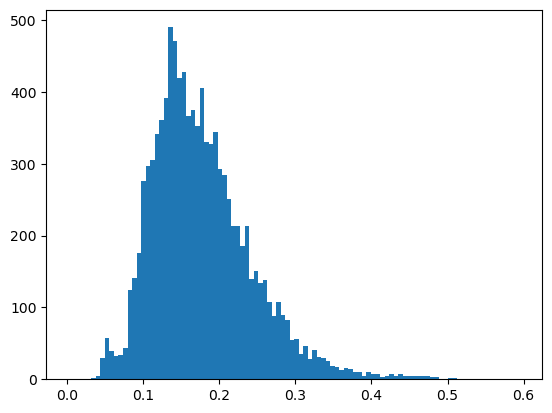

In [70]:
plt.hist(x, bins=100);